# Population genetics: deterministic and stochastic discrete-time models
## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

In [1]:
import random

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import sympy
sympy.init_printing()
import seaborn as sns
from IPython.display import HTML
sns.set_context('talk')

Today we focus on **discrete-time models**.
These models can follow, for example:

- The size of an insect population in year i;
- The proportion of individuals in a population carrying a particular gene in the i-th generation;
- The number of cells in a bacterial culture on day i;
- The concentration of a toxic gas in the lung after the i-th breath;
- The concentration of drug in the blood after the i-th dose.

We will model a population with two distinct **types**, focusing on the change in the frequency of individuals in each of these types from one time point to the next.
These types can model [colored balls](https://en.wikipedia.org/wiki/Polya_urn_model), genes, product, health vs. disease, or even technologies such as USB plug types.

# Conceptual model

Consider a population of $N$ individuals.
$p$ of the individuals are of type $A$, and $1-p$ are of type $B$.
In each reproductive cycle (generation), $A$ and $B$ individuals reproduce at a rate $1+s$ and $1$, where $s>0$ is the selection coefficient of $A$.

This is similar to an urn with $N$ balls, of which $p$ are blue and $1-p$ are red.
At each generation we fill a new urn with balls:
1. we draw a ball from the previous urn, where the odds to draw blue vs red balls is $1+s$.
1. we put a new ball in the new urn with the color of the drawn ball.
1. repeat until the new urn has $N$ balls.

In [2]:
HTML("""<script async class="speakerdeck-embed" data-id="a82ed8531523453d86f7fc09c857749e" data-ratio="1.77777777777778" src="//speakerdeck.com/assets/embed.js"></script>""")

We will start with a simple deterministic one-dimensional model, then develop a stochastic model that adds random sampling.

# Deterministic model

We will consider a *vary large* population with two types, $A$ and $B$.
We'll think about these types as two genetic variants $A$ and $B$, for example, two types of bacteria, one that likes to eat white sugar and one that prefers brown sugar.
Or we could think about ancient humans that can either be hunters or gatherers (assuming that this traits goes from father to son or from mother to daughter).

The assumption of a very large population means that we can use the *law of large numbers* to assume that noise or randomness have very little effect on the dynamics, hence we use a *deterministic* model.
The distinction will become clearer below when we consider a *stochastic* model.

An important concept in this model is **fitness**:

> Fitness is the reproductive success, composed of survival, mating success, fecundity etc. When a trait that affects fitness is heritable -- the offspring have the same trait as the parent -- then it will tend to increase in frequency.

We denote the fitness of $A$ relative to $B$ as $1+s$, hence $s$ is the relative advantage of $A$, or $A$'s **selection coefficient**.
This essentially means that *on average*, $A$ leaves $1+s$ more offspring compared to $B$.

We denote the frequency of $A$ and $B$ as $p$ and $1-p$ and write an equation that describes the frequency of $A$ in the next generation, $p'$:

$$
p' = \frac{p (1+s)}{p (1+s) + 1-p} \quad (1)
$$

where $p (1+s) + 1-p$ is the **mean fitness** of the population, usually denoted $\bar{w}$.

This model is attributed to [Haldane 1924](link.springer.com/article/10.1007%2FBF02459574).

![Haldane](https://www.biografiasyvidas.com/biografia/h/fotos/haldane.jpg)

**[J.B.S. Haldane](https://en.wikipedia.org/wiki/J._B._S._Haldane), 1892-1964**

Let's write a function that iterates eq. 1 a specific number of generations.

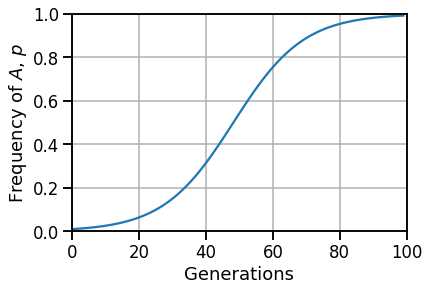

In [3]:
def evolution0(p0, s, tmax):
    p = [p0]

    for t in range(1, tmax):
        p.append( p[t-1] * (1 + s) / (1 + p[t-1] * s) )

    return p

p = evolution0(0.01, 0.1, 100)
plt.plot(p)
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
plt.grid()
plt.xlim(0, len(p));

We call this function `evolution` because, if $A$ and $B$ are different genotypes (i.e. genetic variants), the function describes the change in the frequency of these genotypes -- and this is the formal description of the process of evolution in the field of evolutionary biology.

Let's see how fast evolution is for different strengths of selection $s$, i.e., advantages to $A$ over $B$.

log scale? (y/n): y


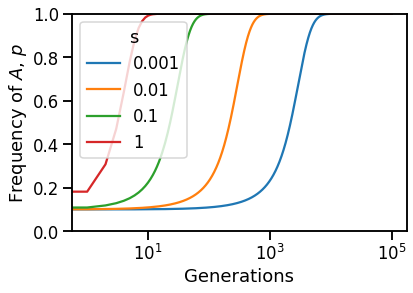

In [4]:
for s in (0.001, 0.01, 0.1, 1):
    plt.plot(evolution0(0.1, s, 100000), label=s)

plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
if input('log scale? (y/n):') == 'y':
    plt.xscale('log')
else:
    plt.xlim(0, len(p))
plt.legend(title='s');

So the strength of selection has a huge effect on the speed of evolution.

## Recurrence solution

The recurrence equation (1) can be solved so that we have an equation of $p(t)$ as a function of time (generations).

Let's write the recurrence for $q_t=(1-p_t)$ the frequency of $B$ (it's a bit easier to solve that way):

$$
q_t = \frac{q_{t-1}}{q_{t-1} + (1-q_{t-1})(1+s)} = 
\frac{q_{t-1}}{q_{t-1} + 1 + s + - q_{t-1} - q_{t-1}s} = \\
\frac{q_{t-1}}{1 + s - q_{t-1}s} = \frac{q_{t-1}}{1 + s(1-q_{t-1})}
$$

If we write the formula for $q_1$ and $q_2$ we can get

$$
q_1 = \frac{q_{0}}{1+s(1-q_{0})} \;, \; q_2 = \frac{q_{1}}{1+s(1-q_{1})} 
$$
<hr width="50%">
$$
q_2 = \frac{q_{1}}{1+s(1-q_{1})} = \frac{\frac{q_{0}}{1+s(1-q_{0})}}{1+s(1-\frac{q_{0}}{1+s(1-q_{0})})} \cdot \frac{1+s(1-q_{0})}{1+s(1-q_{0})} = \\
= \frac{q_0}{1+s(1-q_{0}) + s(1+s(1-q_{0}) - q_0)} = \frac{q_0}{1 + s(1-q_0) + s(1 - q_0 + s(1-q_0))} = \\
= \frac{q_0}{1 + s(1-q_0) + s(1-q_0) + s^2(1-q_0)} = \frac{q_0}{1 + 2s(1-q_0) + s^2(1-q_0)} = \\
= \frac{q_0}{q_0 + (1-q_0)(1+s)^2}
$$

which hints at 

$$
q_t = \frac{q_0}{q_0 + (1-q_0)(1+s)^t}
$$

and equivalently

$$
p_t = 1 - \frac{1-p_0}{1-p_0 + p_0(1+s)^t}
$$


Let's check it numerically:

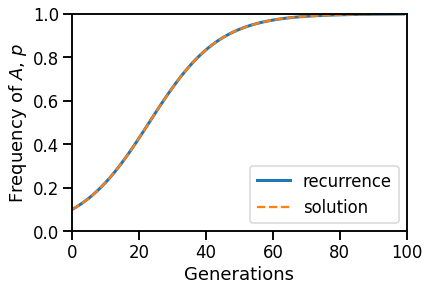

In [173]:
def evolution1(p0, s, tmax):
    return [
        1 - (1-p0)/(1 - p0 + p0 * (1 + s)**t)
        for t in range(int(tmax))
    ]

plt.plot(evolution0(0.1, 0.1, 100), lw=3, label='recurrence')
plt.plot(evolution1(0.1, 0.1, 100), '--', label='solution')
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
plt.legend()
plt.xlim(0, len(p));

Looks good, so we can try and prove it using induction:

$$
q_{t+1} = \frac{q_t}{1+s(1-q_t)} = \\
\frac{\frac{q_0}{q_0 + (1-q_0)(1+s)^t}}{1+s\Big(1-\frac{q_0}{q_0 + (1-q_0)(1+s)^t}\Big)} = \\
\frac{\frac{q_0}{q_0 + (1-q_0)(1+s)^t}}{1+s-\frac{sq_0}{q_0 + (1-q_0)(1+s)^t}} = \\
\frac{q_0}{(1+s)(q_0 + (1-q_0)(1+s)^t) - sq_0} = \\
\frac{q_0}{q_0+s q_0 + (1-q_0)(1+s)(1+s)^{t}) - sq_0} = \\
\frac{q_0}{q_0 + (1-q_0)(1+s)^{t+1})}
$$

which proves the induction.

## Fixation time (deterministic model)

Using the closed form solution of eq. 1, we can find the time for increase from some low frequency $p_0$ to a high frequency $1-p_0$, which will approximate the time it takes type $A$ to dominate the population when it is initially rare -- this is called the **fixation time**.

We want to check in how much time $t$ will it take to get to $1-p_0$ if we started with p_0.

We need to solve the following for $t$:

$$
1-p_0 = 1-\frac{1-p_0}{1-p_0+p_0(1+s)^t} \Rightarrow \\
p_0 = \frac{1-p_0}{1-p_0+p_0(1+s)^t} \Rightarrow \\
(1+s)^t = \frac{(1-p_0)^2}{p_0^2}
$$

Taking the log of both sides

$$
t  = \frac{2\log{[(1-p_0)/p_0}]}{log (1+s)}
$$

If we assume that $p_0\sim 0$ so $(1-p_0)/p_0 \sim p_0^{-1}$ then

$$
t  = \frac{-2\log{p_0}}{log (1+s)}
$$

Let's validate using the numericall iteration.

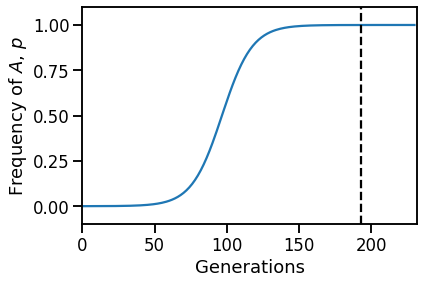

In [174]:
p0 = 1e-4
s = 0.1
t = -2 * np.log(p0) / np.log(1+s)

plt.plot(evolution1(p0, s, 1.2*t), '-')
plt.axvline(t, ls='--', color='k')
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(-0.1, 1.1)
plt.xlim(0, 1.2*t);

Of course, the assumption of a *very large population* breaks when either the population size is not very large, or when the population is very large but one of the type is extermely rare.

Let's start with the second case.

# Stochastic model: large population (not covered in class)

In this case, the population is very large but $A$ is initially very rare, so the dynamics of $A$ while rare are stochastic.

A common model for such dynamics is a **branching process**.

For simplicity, we assume that the number of offspring per individual is Poisson distributed, with mean $1$ for type $B$ and $1+s$ for type $A$.

So the probability that an $A$ individual leaves $k$ offspring is

$$
P(k) = e^{-(1+s)}\frac{(1+s)^k}{k!}
$$

From Otto and Day 2007 (ch. 14.5):

> The key insight made by Haldane (1927) was that the probability that a type ultimately leaves no descendants must equal the probability that each offspring produced by this type leaves no descendants.

So we can write

$$
p_{loss} = \sum_{k=0}^{\infty}{p_{loss}^k P(k)} = \\
e^{-(1+s)} \sum_{k=0}^{\infty}{\frac{\big((1+s)p_{loss}\big)^k}{k!}} = \\
e^{-(1+s)} e^{p_{loss}(1+s)}
$$

where the last transition is due to the Taylor expansion on the exponential function.

So we get 

$$
p_{loss} = e^{-(1-p_{loss})(1+s)}
$$

The solution to these relationship cannot be expressed using elementary functions, and in fact, the solution is called a [Lambert W function](https://en.wikipedia.org/wiki/Lambert_W_function).

We can find the specific Lambert W function which solves this relationship using with [SymPy](http://sympy.org), a Python framework for symbolic mathematics:

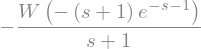

In [203]:
ploss, s = sympy.symbols('p_{loss} s')
eq = ploss - sympy.exp(-(1 - ploss) * (1 + s))
sol = sympy.solve(eq, ploss)[0]

sol

Let's plot the result:

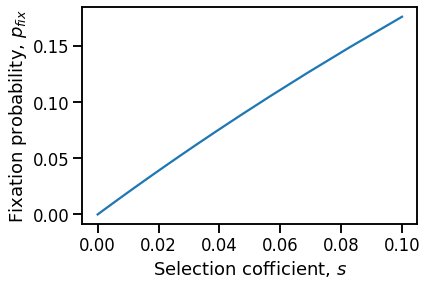

In [204]:
s = np.logspace(-5, -1)
pfix = [1 - sol.evalf(subs=dict(s=s_)) for s_ in s]

plt.plot(s, pfix)
plt.xlabel('Selection cofficient, $s$')
plt.ylabel('Fixation probability, $p_{fix}$');

This solution (the Lambert W function) is fine for numerical applications, but not so much if we want to understand the result.

We can rewrite the formula in terms of $p_{fix}=1-p_{loss}$:

$$
p_{fix} = 1-e^{-(1+s)p_{fix}} 
$$

If we assume that $s$ and $p_{fix}$ are both *small* (i.e. porportional to some small $\epsilon$), we can use the Taylor expansion for the exponential function (again) to get, up to term of order $o(\epsilon^3)$,

$$
p_{fix} \approx (1+s)p_{fix} - \frac{1}{2}\big((1+s)p_{fix}\big)^2
$$

To solve this we do some algebra and use the quadratic formula

$$
p_{fix} - (1+s)p_{fix} + \frac{1}{2}\big((1+s)p_{fix}\big)^2 = 0 \Rightarrow \\
\frac{1}{2}(1+s)^2 p_{fix}^2 -s p_{fix} = 0 \Rightarrow \\
p_{fix} = \frac{s \pm s}{(1+s)^2}
$$

So we get that $p_{fix} \approx \frac{s+s}{1+s}$, and since $s$ is small, we have $p_{fix} \approx 2s$.

Let's compare it to the full result (the Lambert W function).

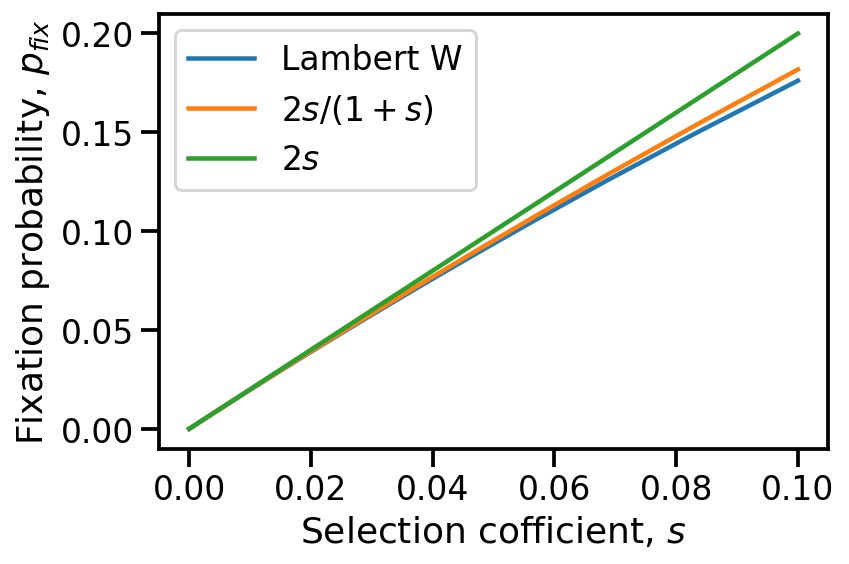

In [9]:
plt.plot(s, pfix, label='Lambert W')
plt.plot(s, 2*s/(1+s), label='$2s/(1+s)$')
plt.plot(s, 2*s, label='$2s$')
plt.xlabel('Selection cofficient, $s$')
plt.ylabel('Fixation probability, $p_{fix}$');
plt.legend();

So we can use one of the two approximations, depending on the value $s$.

# Stochastic model: small population

In a small population, random effects can affect the dynamics even when both types are common.

We will use the **Wright-Fisher model**:
at each generation the number of offspring of type $A$, which we mark $n$ , is binomially distributed $Bin(N, p)$, where $p$ is the frequency of $A$ parents.

![Sewall Wright](https://upload.wikimedia.org/wikipedia/en/8/81/Sewall_Wright.jpg)

**[Sewall Wright](https://en.wikipedia.org/wiki/Sewall_Wright), 1889 - 1988**

![R.A. Fisher](http://www.economics.soton.ac.uk/staff/aldrich/fisherguide/Doc1_files/image001.gif)

**[R.A. Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher), 1890 - 1972**

### Pure Python implementation

First we implement the model using a pure Python function.

Of course, everytime we run the simulation we will get a different result (yay randomness).

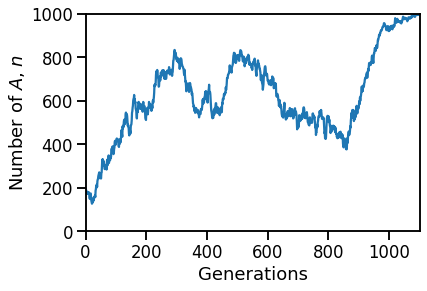

In [178]:
def simulation_py(n0, N, s):
    n = [n0]

    while 0 < n[-1] < N:
        p = n[-1] * (1 + s) / (N + n[-1] * s)
        sample = ( # generator expression
            1 
            for _ in range(N) 
            if random.random() < p
        )
        n.append(sum(sample))

    return n

n0 = 200 
N = 1000
s = 0.001

n = simulation_py(n0, N, s)

plt.plot(n)
plt.xlabel('Generations')
plt.ylabel('Number of $A$, $n$')
plt.ylim(0, N)
plt.xlim(0, len(n));

In [112]:
%timeit simulation_py(n0=200, N=1000, s=0.1)
%timeit simulation_py(n0=2000, N=10000, s=0.1)

13.5 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
160 ms ± 4.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


This becomes slow when $N$ is large, but we don't really care too much because when $N$ is large we can use the deterministic model.

But still, we can do faster than that using NumPy.

### NumPy implementation

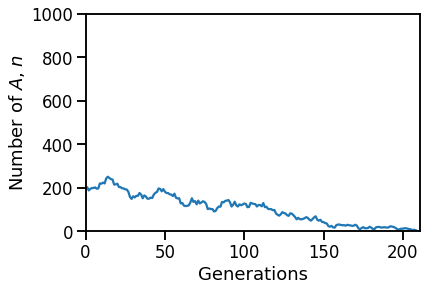

In [207]:
def simulation_np(n0, N, s, buflen=1000):
    n = np.empty(buflen)
    n[0] = n0
    t = 0
    while 0 < n[t] < N:        
        p = n[t] * (1 + s) / (N + n[t] * s)
        t += 1
        if t == len(n):
            n = np.append(n, np.empty(buflen))
        n[t] = np.random.binomial(N, p)

    return n[:t+1].copy()


n0 = 200 
N = 1000
s = 0.001

n = simulation_np(n0, N, s)

plt.plot(n)
plt.xlabel('Generations')
plt.ylabel('Number of $A$, $n$')
plt.ylim(0, N)
plt.xlim(0, len(n));

In [114]:
%timeit simulation_np(n0=200, N=1000, s=0.1)
%timeit simulation_np(n0=2000, N=10000, s=0.1)

492 µs ± 22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
673 µs ± 103 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


This is much faster than the pure Python implementation, and the differences between population sizes is smaller.

Can we do even faster?

## Multiple simulations

Since the dynamics are random, we will want to run many replications of the simulation and collect some statistics.

### Pure Python

In [180]:
%%time

def simulations_py(n0, N, s, repetitions=10):
    return [
        simulation_py(n0, N, s) 
        for _ in range(repetitions)
    ]

n = simulations_py(n0, N, s, 100)

CPU times: user 15.7 s, sys: 57 ms, total: 15.8 s
Wall time: 16.4 s


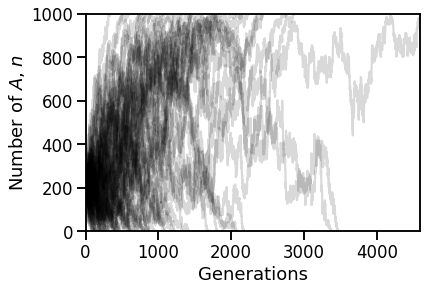

In [181]:
for n_ in n:
    plt.plot(n_, 'k', alpha=0.15)
plt.xlabel('Generations')
plt.ylabel('Number of $A$, $n$')
plt.ylim(0, N)
plt.xlim(0, max(len(n_) for n_ in n));

In [26]:
%timeit simulations_py(200, 1000, 0.1, 100)
%timeit simulations_py(2000, 10000, 0.1, 100)

1.05 s ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.7 s ± 637 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### NumPy

We can do faster with NumPy.

In [1]:
def simulations_np(n0, N, s, repetitions=10, buflen=1000):
    # Each individual simulation is a column because `plt.plot(n)` plots all the columns
    n = np.zeros((buflen, repetitions))
    n[0,:] = n0
    t = 0
    update = (n[t] > 0) & (n[t] < N)
    while update.any():
        t += 1
        p = n[t-1] * (1 + s) / (N + n[t-1] * s)
        if t == n.shape[0]:
            n = np.concatenate((n, np.zeros((buflen, repetitions))))
        n[t, update] = np.random.binomial(N, p[update])
        n[t, ~update] = n[t-1, ~update]
        update = (n[t] > 0) & (n[t] < N)

    return n[:t+1].copy()

n = simulations_np(n0, N, s, 100)
plt.plot(n, 'k', alpha=0.15)
plt.xlabel('Generations')
plt.ylabel('Number of $A$, $n$')
plt.ylim(0, N)
plt.xlim(0, n.shape[0]);

NameError: name 'n0' is not defined

This is a more sophisticated way to visualize the same result.

The x-axis is still time; the y-axis represents the repitions (or population), and the color denotes the frequency of type $A$, from dark for zero to bright for 1.

The repetitions are ordered by the average frequency of type $A$ over the entire simulation duration, so that simulations with quick fixation of $A$ are at the top, simulations with quick extinction of $A$ are at the bottom, and simulations that took a long time to end are at the middle.

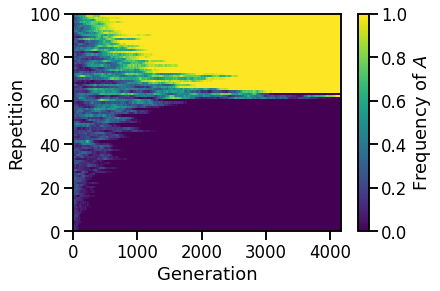

In [224]:
idx = n.mean(axis=0).argsort()
plt.pcolormesh(n[:, idx].T / N)
plt.colorbar(label='Frequency of $A$')
plt.xlabel('Generation')
plt.ylabel('Repetition');

In [121]:
%timeit simulations_np(n0=200, N=1000, s=0.1, repetitions=1000)
%timeit simulations_np(n0=2000, N=10000, s=0.1, repetitions=1000)

29.4 ms ± 4.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
31.5 ms ± 755 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can see that the NumPy implementation is much faster.

## Fixation probability (stochastic model)

If we want to estimate the fixation probability (the probability that type A takes over the population), we don't actually need to save the entire `n` array.

In [186]:
def fix_prob(n0, N, s, repetitions=10):
    '''
    n0 - The initial size of pop. A
    N - The total pop. size
    s - The relative advantage of A
    '''
    N = int(N)
    n = np.repeat(n0, repetitions)
    n[:] = n0 # broadcasting
    update = (n > 0) & (n < N)
    while update.any():
        p = n * (1 + s) / (N + n * s)
        n[update] = np.random.binomial(N, p[update])
        update = (n > 0) & (n < N)
    

    return (n == N).mean()

fix_prob(1, 100, 0.1, 100_000)

This saves both memory and CPU.

In [147]:
%timeit n = simulations_np(1, 100, 0.1, 100000); (n[-1,:]==N).mean()
%timeit fix_prob(1, 100, 0.1, 100000)

973 ms ± 60.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
548 ms ± 57.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now let's plot the fixation probability for different population sizes; we expect it to converge to the deterministic result $2s$ for large populations.

In [187]:
Ns = np.logspace(1, 6, 100, dtype=int)
s = 0.001
n0 = 1

pfix = [fix_prob(n0, N, s, 1000) for N in Ns]

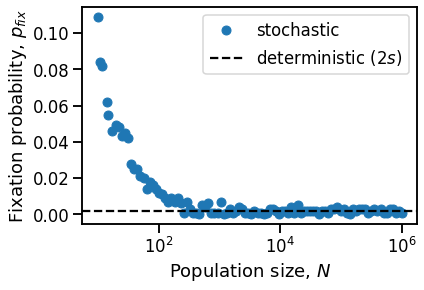

In [188]:
plt.plot(Ns, pfix, 'o', label='stochastic')
plt.axhline(2*s, ls='--', color='k', label='deterministic $(2s)$')

plt.xlabel('Population size, $N$')
plt.xscale('log')
plt.ylabel('Fixation probability, $p_{fix}$')
plt.legend();

## Diffusion equation approximation for fixation probability

There is a rather good approximation even for small population sizes.
Using a diffusion equation approximation, [Kimura (1962)](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC1210364/) reached his famous equation:

$$
\frac{1 - e^{-2 n_0 s}}{1 - e^{-2 N s}}
$$

For large $N$, the denominator is roughly 1, and if $s$ is small than we can approximate this by $2s$. 

For a modern derivation see Durrett's [Probability Models for DNA Sequence Evolution](https://services.math.duke.edu/~rtd/Gbook/Gbook.html), ch. 7 (free online).

[![Kimura](https://upload.wikimedia.org/wikipedia/en/4/48/Motoo_Kimura.jpg)](https://en.wikipedia.org/wiki/Motoo_Kimura)

**Motoo Kimura, 1924 - 1994**

In [150]:
def fix_kimura(n0, N, s):
    return np.expm1(-2 * n0 * s) / np.expm1(-2 * N * s)

Note the use of `expm1(x)` which is more precise than `exp(1-x)` for small `x` values.

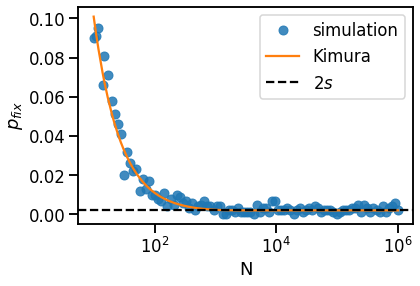

In [158]:
plt.plot(Ns, pfix, 'o', alpha=0.85, label='simulation')
plt.plot(Ns, fix_kimura(n0, Ns, s), '-', label='Kimura')
plt.axhline(2*s/(1+s), ls='--', c='k', label='$2s$')

plt.xlabel('N')
plt.xscale('log')
plt.ylabel('$p_{fix}$')
plt.legend();

This approximation does the job very well.

Behold the power of NumPy's `ufunc`:

In [159]:
Ns_ = np.logspace(1, 6, 5000, dtype=np.int64)
%timeit [fix_kimura(n0, N, s) for N in Ns_]
%timeit fix_kimura(n0, Ns_, s)

30.1 ms ± 255 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
66.5 µs ± 133 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Numba implementation

[Numba](http://numba.pydata.org/) is a JIT compiler for Python and NumPy built over LLVM

In [163]:
import numba

fix_kimura_nm = numba.jit(fix_kimura)
fix_kimura_nm(n0, N, s); # burn-in for the jit to work

In [164]:
Ns = np.logspace(1, 6, 100, dtype=float)
%timeit fix_kimura(n0, Ns, s)
%timeit fix_kimura_nm(n0, Ns, s)

7.09 µs ± 39.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.95 µs ± 217 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [165]:
Ns = np.logspace(1, 6, 10000, dtype=float)
%timeit fix_kimura(n0, Ns, s)
%timeit fix_kimura_nm(n0, Ns, s)

197 µs ± 58.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
139 µs ± 5.81 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Fixation time (stochastic) (not covered in class)

Now we will focus on the *time* it takes for the fixation of one of the type to occur.

In [166]:
def fix_time(n0, N, s, repetitions=10):
    N = int(N)
    n = np.repeat(n0, repetitions)
    T = np.repeat(np.inf, repetitions)
    
    t = 0
    n[:] = n0
    update = (n > 0) & (n < N)
    while update.any():        
        p = n * (1 + s) / (N + n * s)
        n[update] = np.random.binomial(N, p[update])
        update = (n > 0) & (n < N)
        t += 1
        T[~update] = np.minimum(T[~update], t)
    return n == N, T

In [167]:
n0 = 10
N = 1000
s = 0.01
fixations, times = fix_time(n0, N, s, 100000)

We'll plot the distribution of waiting time for fixation of $A$ and for extinction of $A$.

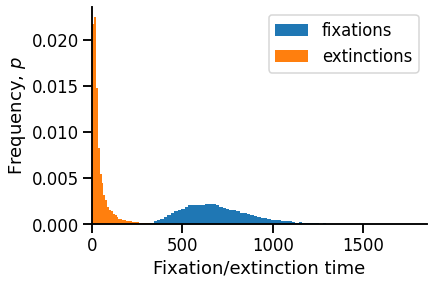

In [168]:
fig, ax = plt.subplots()

ax.hist(times[fixations], bins=100, density=True, label='fixations')
ax.hist(times[~fixations], bins=100, density=True, label='extinctions')

ax.set(
    xlim=(0, -4 * np.log(n0/N) / np.log(1+s)),
    xlabel='Fixation/extinction time',
    ylabel='Frequency, $p$'
)
ax.legend()
sns.despine()

### Deterrministic approximation

We can now compare the expected fixation time to an approximation derived from the deterministic model (eq. 1).

In [197]:
def mean_std_fix_time(fixations, times):
    fix_times = times[fixations]
    return fix_times.mean(), fix_times.std(ddof=1)

n0 = 1
Ns = np.logspace(1, 8, 50, dtype=int)
s = 0.01
fix_times = np.array([
    mean_std_fix_time(*fix_time(n0, N, s, 10000)) 
    for N in Ns
])

The deterministic approximation is
$$
T_{approx} = -2 \frac{log(p_0)}{log{(1+s)}}
$$

(can you derive this on your own?)

In [195]:
def T_haldane(n0, Ns, s):
    return -2 * np.log(n0/Ns) / np.log(1+s)

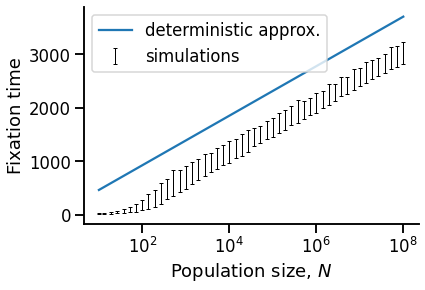

In [198]:
plt.errorbar(Ns, fix_times[:,0], yerr=fix_times[:,1], 
             capsize=2, capthick=1, lw=0, label='simulations',
             ecolor='k', elinewidth=1)
plt.plot(Ns, T_haldane(n0, Ns, s), label='deterministic approx.')
plt.xscale('log')
plt.xlabel('Population size, $N$')
plt.ylabel('Fixation time')
plt.legend()
sns.despine()

We can see that the deterministic approximation constantly over estimates the fixation time.

Can we have a better approximation?

### Diffusion equation approximation for fixation time

Another approximation of the fixation time is based on a diffusion equation and is given in [Kimura and Ohta 1969](http://www.pubmedcentral.nih.gov/articlerender.fcgi?artid=1212239) (eq. 17). It assumes a population size of $2N$ gametes and selection advantage of $s/2$ rather then $N$ and $s$, therefore I'm changing $s=2s$ and $N=N/2$. Also, it has the initial frequency as $x$, so we define $x=n_0/N$.

$$
I_1(x) = \frac{1 - e^{-2 n_0 s} - e^{-2Ns(1-x)} + e^{-2Ns}}{x(1-x)} \\
I_2(x) = \frac{(e^{2Nsx} - 1) (1 - e^{-2Ns(1-x)})}{x(1-x)} \\
J_1 = \frac{1}{s(1-e^{-2Ns})} \int_{x}^{1}{I_1(y) dy} \\
J_2 = \frac{1}{s(1-e^{-2Ns})} \int_{0}^{x}{I_2(y) dt} \\
u = \frac{1 - e^{-2Nsx}}{1 - e^{-2Ns}} \\
T_{fix} = J1 + \frac{1-u}{u} J_2
$$

For a modern derivation see Durrett's [Probability Models for DNA Sequence Evolution](https://services.math.duke.edu/~rtd/Gbook/Gbook.html), ch. 7 (free online).

Here we need to integrate some functions, we'll do this using `scipy.integrate.quad`. 

`functools.partial` reduces the number of arguments a function expects, effectively freezing some of them - mathematically, it creates a projection.

`np.vectorize` is a decorator that converts a scalar function to an array function, giving it the `ufunc` super powers.

In [191]:
from scipy.integrate import quad 
from functools import partial

def integral(f, N, s, a, b):
    f = partial(f, N, s)    
    return quad(f, a, b)[0]

In [199]:
def I1(N, s, x):
    if x == 1:
        return 0
    return (1 - np.exp(-2*N*s*x) - np.exp(-2 * N * s * (1 - x)) + np.exp(-2 * N *s)) / (x*(1-x))

def I2(N, s, x):
    if x == 0:
        return 0
    return -np.expm1(2 * N * s * x) * np.expm1(-2 * N * s * x) / (x * (1 - x))

@np.vectorize
def T_kimura(n0, N, s):
    x = n0 / N
    J1 = -1.0 / (s * np.expm1(-2 * N * s)) * integral(I1, N, s, x, 1)
    u = np.expm1(-2 * N * s * x) / np.expm1(-2 * N * s)
    J2 = -1.0 / (s * np.expm1(-2 * N *s)) * integral(I2, N, s, 0, x)
    return J1 + ((1 - u) / u) * J2

assert 254 < T_kimura(1, 1e6, 0.1) < 255

Behold the power of `np.vectorize`.

In [200]:
Ns = np.logspace(1, 6, 100)
%timeit np.array([T_kimura(n0, N, s) for N in Ns])
%timeit T_kimura(n0, Ns, s)

434 ms ± 77.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
133 ms ± 386 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's compare the simulation results with the two approximations:

In [201]:
n0 = 1
Ns = np.logspace(1, 8, 50, dtype=int)
s = 0.01

fix_time_kimura = T_kimura(n0, Ns, s)
fix_time_haldane = T_haldane(n0, Ns, s)

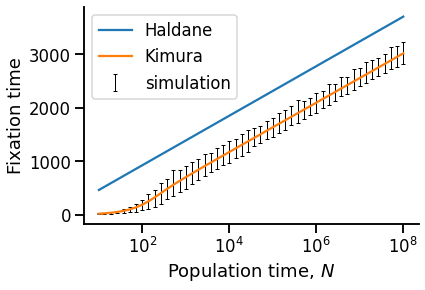

In [202]:
plt.errorbar(Ns, fix_times[:,0], yerr=fix_times[:,1], 
             capsize=2, capthick=1, lw=0, label='simulation',
             ecolor='k', elinewidth=1)
plt.plot(Ns, fix_time_haldane, label='Haldane')
plt.plot(Ns, fix_time_kimura, label='Kimura')

plt.xscale('log')
plt.xlabel('Population time, $N$')
plt.ylabel('Fixation time')
plt.legend()
sns.despine()

Kimura's diffusion approximation is fantastic.

# Bonus: Multi-type model (not covered in class)

The above simulations are hard to extend for a multi-type model in which there are more than two types, because we used scalar arithmetics and the binomial distribution.

The following is a multi-type extension that uses matrix multiplication and the multinomial distribution.

There are now $L$ different types; the fitness of type $k$ is $(1+s)^k$; type $k$ can mutate to types $k-1$ and $k+1$ with probability $m$.

For experimental work related to this (including model-based analysis) see works by [Noah Ribeck](https://scholar.google.com/citations?user=FK7uVqsAAAAJ&hl=en&oi=ao) on the long-term evolutionary experiment.

In [39]:
def simulation(N, s, m, L, repetitions=1000):
    assert N > 0
    N = np.uint64(N)
    
    w = (1 + s) ** np.arange(L)
    S = np.diag(w)
    
    M = np.diag(np.repeat(1 - 2 * m, L))
    M += np.diag(np.repeat(m, L - 1), 1)
    M += np.diag(np.repeat(m, L - 1), -1)
    
    E = M @ S

    # rows are genotypes, cols are repretitions
    n = np.zeros((L, repetitions))
    n[0,:] = N    
    # which columns to update
    update = np.array([True] * repetitions)
    # follow time
    T = np.zeros(repetitions)
    t = 0
    # follow population mean fitness
    W = []
    
    while update.any():
        t += 1
        T[update] = t        
        p = n/N  # counts to frequencies
        W.append(w.reshape(1, L) @ p)  # mean fitness
        p = E @ p  # natural selection + mutation        
        p /= p.sum(axis=0)  # mean fitness
        for j in update.nonzero()[0]:
            # random genetic drift
            n[:,j] = np.random.multinomial(N, p[:,j])
        update = (n[-1,:] < N)  # fixation of fittest genotype
        
    return T, W

In [40]:
N=10000
s=0.1
m=1e-4
L=5

times, fitness = simulation(N, s, m, L, repetitions=1000)
print("Adaptation time: {:.2f}".format(times.mean()))

Adaptation time: 441.73


In [41]:
import pandas as pd

Put fitness data in a pandas data frame:

In [42]:
fitness = np.array(fitness).squeeze()
df = pd.DataFrame(data=fitness)
df['Time'] = df.index
df.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,Time
0,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0
1,1.00002,1.00000,1.00003,1.00001,1.00000,1.00001,1.00003,1.00001,1.00000,1.00001,...,1.00000,1.00001,1.00002,1.00003,1.00001,1.00000,1.00000,1.00000,1.00001,1
2,1.00003,1.00000,1.00006,1.00003,1.00003,1.00007,1.00003,1.00003,1.00002,1.00002,...,1.00001,1.00002,1.00001,1.00004,1.00004,1.00002,1.00000,1.00001,1.00003,2
3,1.00006,1.00001,1.00004,1.00005,1.00002,1.00009,1.00004,1.00005,1.00004,1.00004,...,1.00002,1.00003,1.00001,1.00008,1.00004,1.00004,1.00001,1.00004,1.00002,3
4,1.00005,1.00002,1.00006,1.00010,1.00003,1.00014,1.00005,1.00008,1.00003,1.00003,...,1.00003,1.00001,1.00001,1.00010,1.00009,1.00010,1.00001,1.00006,1.00005,4


Melt the data frame so that each fitness value has its own row:

In [43]:
df = pd.melt(df, id_vars='Time', var_name='Replicate', value_name='Fitness')
df.head()

,Time,Replicate,Fitness
0,0,0,1.00000
1,1,0,1.00002
2,2,0,1.00003
3,3,0,1.00006
4,4,0,1.00005


Now group by `Time` and calculate the average fitness across all replicates. `reset_index` recreates the `Time` column.

In [44]:
mean_df = df.groupby('Time')['Fitness'].mean().reset_index()
mean_df.head()

,Time,Fitness
0,0,1.000000
1,1,1.000010
2,2,1.000021
3,3,1.000033
4,4,1.000046


Now draw a random sample of 5% of simulations:

In [45]:
grp = df.groupby('Replicate')
filtered = grp.filter(lambda x: random.random() < 0.05)

Pivot the table - this is the reverse of `melt`:

In [46]:
pivoted = filtered.pivot('Time', 'Replicate', 'Fitness')
pivoted.head()

Replicate,16,23,81,156,163,167,203,204,215,253,...,625,654,698,851,855,865,871,875,906,922
Time,,,,,,,,,,,,,,,,,,,,,
0,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
1,1.00004,1.00000,1.00002,1.00000,1.00002,1.00001,1.00001,1.00001,1.00002,1.00000,...,1.00000,1.00002,1.00002,1.00000,1.00001,1.00000,1.00000,1.00001,1.00003,1.00001
2,1.00003,1.00003,1.00002,1.00000,1.00001,1.00002,1.00002,1.00001,1.00004,1.00002,...,1.00000,1.00004,1.00001,1.00004,1.00000,1.00000,1.00001,1.00001,1.00004,1.00000
3,1.00006,1.00002,1.00003,1.00000,1.00003,1.00000,1.00006,1.00002,1.00000,1.00002,...,1.00001,1.00006,1.00002,1.00005,1.00000,1.00000,1.00001,1.00001,1.00006,1.00001
4,1.00006,1.00002,1.00006,1.00002,1.00008,1.00003,1.00007,1.00002,1.00000,1.00003,...,1.00003,1.00010,1.00006,1.00007,1.00000,1.00002,1.00002,1.00005,1.00005,1.00000


We are now ready to plot. 

The left plot is similar to the fixation time plots from above and gives the distribution of times to fixation of the favored type.

The right plot is new: we plot 5% of the simulations using colored solid lines and the average line using a thick black dashed line. The gray line marks the expected theoretical final population mean fitness.

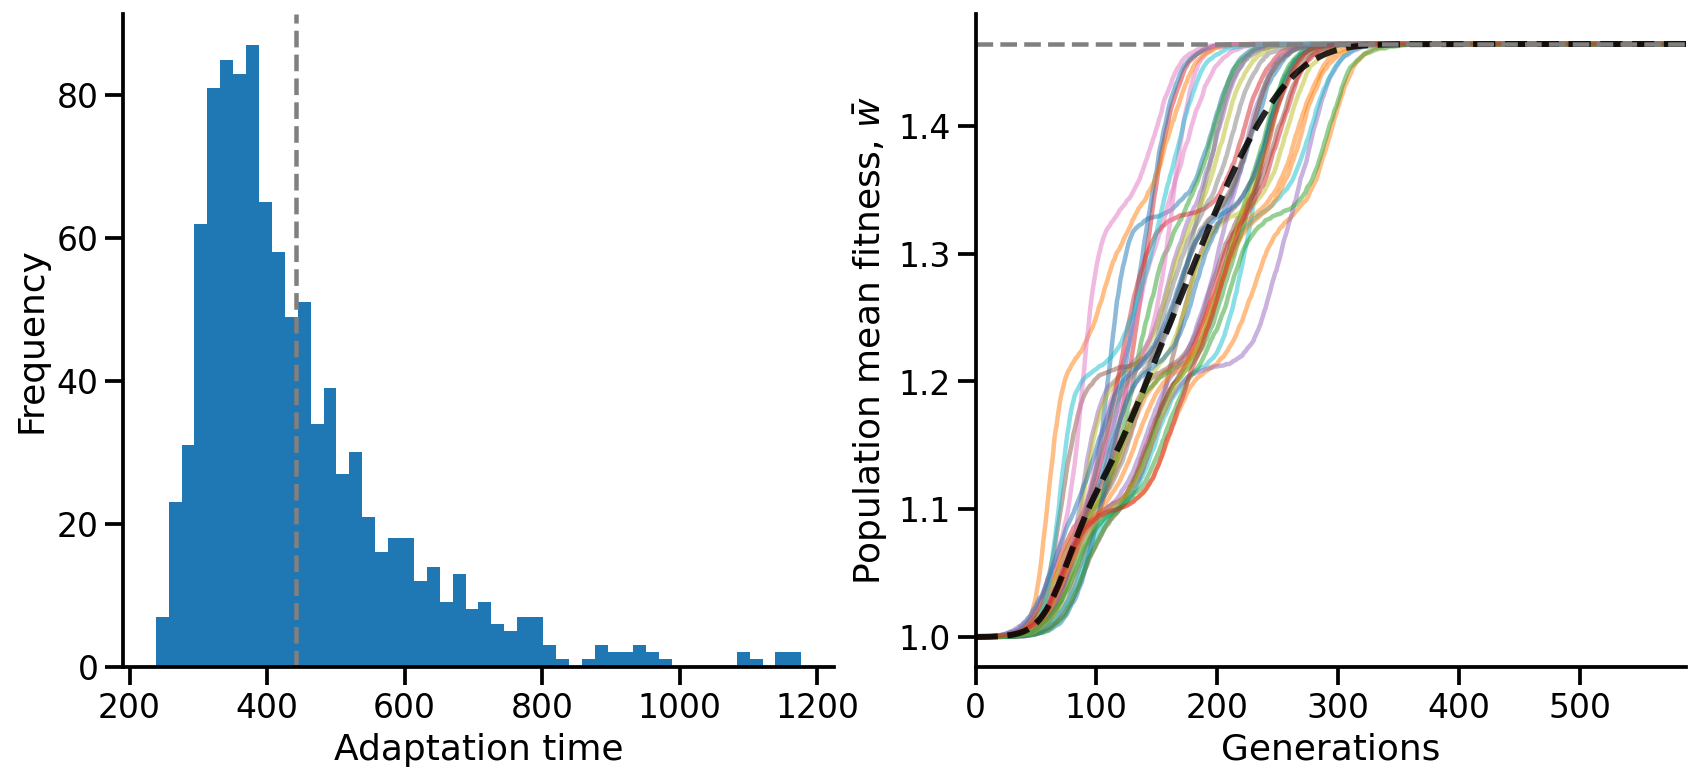

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].hist(times, bins=50)
ax[0].axvline(times.mean(), color='gray', ls='--')
ax[0].set(xlabel='Adaptation time', ylabel='Frequency')

pivoted.plot(ax=ax[1], alpha=0.5)
mean_df.plot('Time', 'Fitness', color='k', alpha=0.85, ls='--', lw=3, ax=ax[1])
ax[1].axhline((1 + s)**(L - 1) * (1 - 2 * m), color='gray', ls='--')
ax[1].legend().set_visible(False)
ax[1].set(xlabel='Generations', ylabel=r'Population mean fitness, $\bar{w}$', xlim=(0, df.Time.max()/2))

sns.despine()

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Scientific Computing with Python_](https://scicompy.yoavram.com/) course at IDC Herzliya.

The notebook was written using [Python](http://python.org/) 3.6.5.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)